In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from tqdm import tqdm
import utils.augmentation as aug
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model
from keras.layers import TimeDistributed

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [3]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

In [4]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [5]:
#SHUFFLE DATA
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [6]:
#NAME OF THE FEATURES COLUMNS
feature_names = ['Attribute-0', 'Attribute-1', 'Attribute-2', 'Attribute-3', 'Attribute-4', 'Attribute-5']
#COLUMNS NAMES (include ID and TARGET and all features)
columns = feature_names.copy()
columns.insert(0, 'ID')
columns.append('Target')

In [7]:
def add_shift(df, column_names=None, shift=1, avg=False):
    if column_names is None:
        column_names = []
    if avg:
        new_columns = [item + " - A" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].rolling(shift).mean()
    else:
        new_columns = [item + " - S" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].shift(shift)

    #Replace Nan with 0
    df[new_columns] = df[new_columns].replace(np.nan, 0)
    return df

In [8]:
X = pd.DataFrame(columns=columns)
remove_shifts = True
for i in tqdm(range(0, data.shape[0])):
    new_seq = pd.DataFrame(data[i], columns=feature_names)
    new_seq['Target'] = target[i]
    new_seq['ID'] = i
    if not remove_shifts:
        new_seq = add_shift(new_seq, feature_names, shift=2)
        new_seq = add_shift(new_seq, feature_names, shift=5)
        new_seq = add_shift(new_seq, feature_names, shift=5, avg=True)
        new_seq = add_shift(new_seq, feature_names, shift=10)
        new_seq = add_shift(new_seq, feature_names, shift=10, avg=True)
    X = pd.concat([X, new_seq])

X.shape

100%|██████████| 2429/2429 [00:02<00:00, 977.17it/s] 


(87444, 8)

In [16]:
feature_names = X.columns[X.columns != 'ID']
feature_names = feature_names[feature_names != 'Target']
feature_names = feature_names.tolist()
feature_names

['Attribute-0',
 'Attribute-1',
 'Attribute-2',
 'Attribute-3',
 'Attribute-4',
 'Attribute-5']

In [17]:
def inspect_activity(activity, df):
    data = df[df['Target'] == activity][feature_names]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

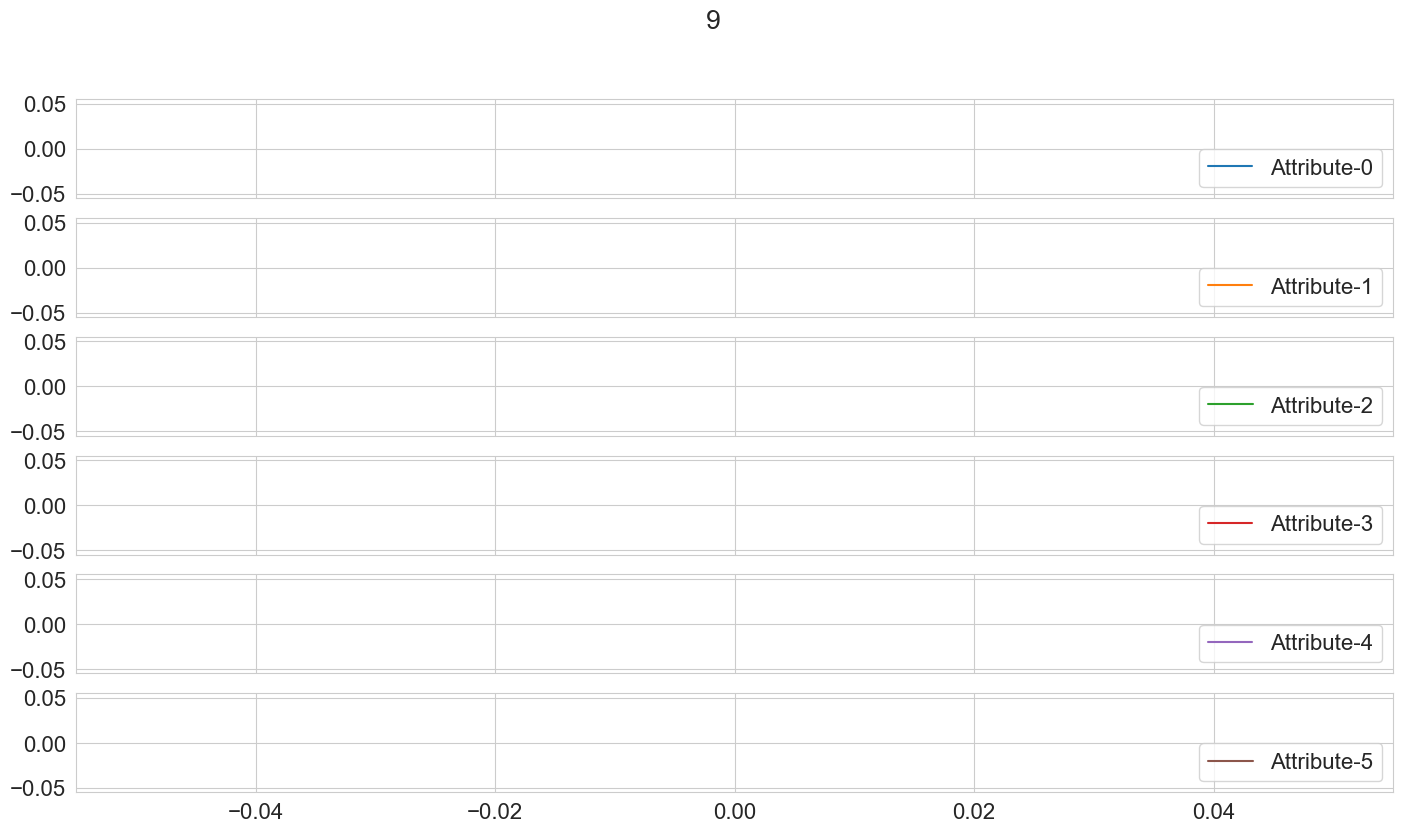

In [18]:
class_to_plot = 9
inspect_activity(class_to_plot, X.head(360))

In [19]:
test_split = 0.2
test_split_ID = data.shape[0] - test_split * data.shape[0]

# Split over users
df_train = X[X['ID'] <= test_split_ID]
df_test = X[X['ID'] > test_split_ID]
X.set_index('ID')
df_train.shape, df_test.shape

((69984, 8), (17460, 8))

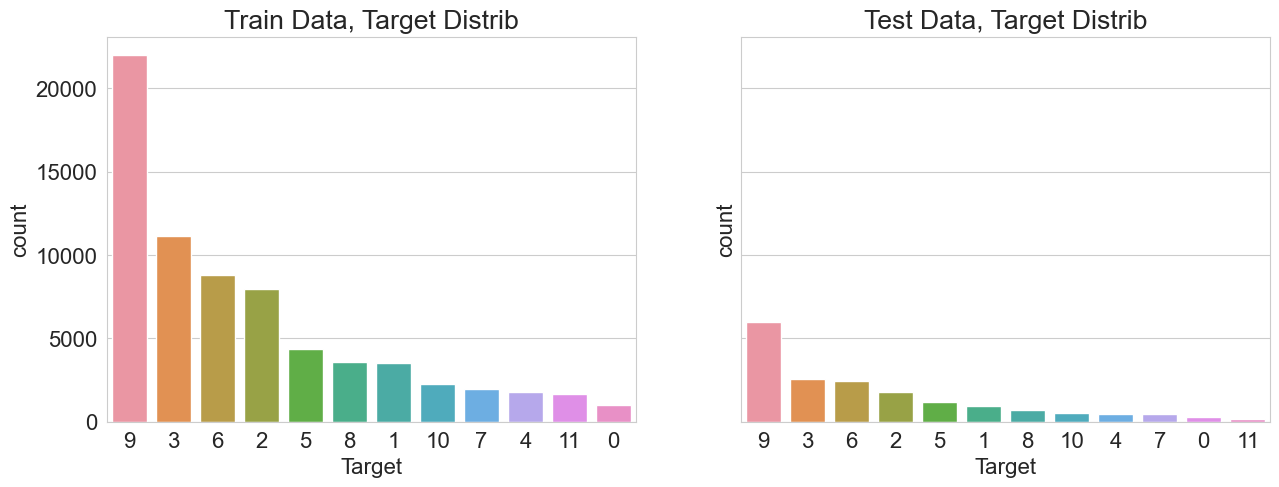

<Figure size 1700x500 with 0 Axes>

In [20]:
# Inspect activities timestamps
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=df_train, order=df_train.Target.value_counts().index, ax=axs[0])
axs[0].set_title('Train Data, Target Distrib')
# Inspect activities timestamps
sns.countplot(x='Target', data=df_test, order=df_test.Target.value_counts().index, ax=axs[1])
axs[1].set_title('Test Data, Target Distrib')
plt.show()

In [21]:
# Apply MinMaxScaler to the useful features
normalize = False
norm_type = 2 # 0 -> MinMax, 1 Mean(0) Std dev(1)

#NORMALIZE DATA
if normalize:
  #MinMax
  if norm_type == 0:
    min = df_train[feature_names].min()
    max = df_train[feature_names].max()
    df_train[feature_names]=(df_train[feature_names]-min)/(max - min)
    df_test[feature_names] = (df_test[feature_names]-min)/(max - min)
  #Mean,Std
  if norm_type == 1:
    mean = df_train[feature_names].mean()
    var  = df_train[feature_names].std()
    df_train[feature_names]=(df_train[feature_names]-mean)/var
    df_test[feature_names] = (df_test[feature_names]-mean)/var
  if norm_type == 2:
    df_train = normalizeSingleSerie(df_train)
    df_test  = normalizeSingleSerie(df_test)

df_train

/var/folders/0y/xb7crskj6j96cb2cmd4bsvm00000gn/T/ipykernel_9347/488657213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[feature_names] = (df_train[feature_names] - mean) / var
/var/folders/0y/xb7crskj6j96cb2cmd4bsvm00000gn/T/ipykernel_9347/488657213.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[feature_names] = (df_test[feature_names] - mean) / var


,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,-0.206729,1.459003,-0.704565,1.294668,-1.049340,0.545246,10
1,0,-0.189990,1.519634,-1.080466,1.284274,-1.592723,0.557888,10
2,0,-0.155180,1.465893,-0.789685,0.659385,-1.169494,0.430910,10
3,0,-0.107876,1.302462,0.009332,0.259477,0.134961,0.404355,10
4,0,-0.057233,1.048939,0.449265,0.529962,1.075577,0.642488,10
...,...,...,...,...,...,...,...,...
31,1943,0.804642,0.249261,0.210924,0.277711,0.270851,0.393939,8
32,1943,0.798716,0.418920,0.369385,0.468700,0.475030,0.604932,8
33,1943,0.703696,0.359500,0.313353,0.398624,0.402851,0.497959,8
34,1943,0.609300,0.291262,0.254534,0.315918,0.320283,0.425259,8


In [22]:
def build_sequence(df):
    x = df.groupby('ID')[feature_names].apply(lambda x: x.values.tolist()).tolist()
    y = df.groupby(['ID', 'Target'])[['Target']].mean()

    return np.array(x), np.array(y)

In [23]:
x_train, y_train = build_sequence(df_train)
x_test, y_test = build_sequence(df_test)
#X,Y = build_sequence(X) -> TEST IF TARGET ARE EXTRACTED IN CORRECT ORDER (WORK)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1944, 36, 6), (1944, 1), (485, 36, 6), (485, 1))

# Augmentation


In [24]:
import utils.augmentation as aug


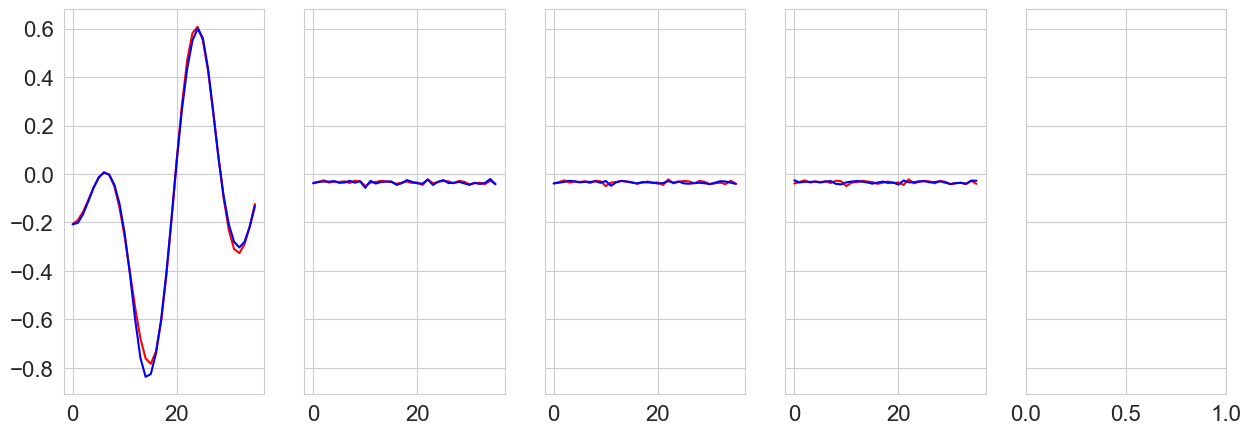

In [25]:
fig, ax =  plt.subplots(1, 5, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(aug.magnitude_warp(x_train, sigma=0.1, knot=10)[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(aug.jitter(x_train, sigma=0.005)[2, :, 0], color="blue")

ax[2].plot(x_train[2, :, 0], color="red")
ax[2].plot(aug.time_warp(x_train)[2, :, 0], color="blue")

ax[3].plot(x_train[2, :, 0], color="red")
ax[3].plot(aug.window_slice(x_train)[2, :, 0], color="blue")

plt.show()

In [26]:
x_train = np.append(x_train, aug.jitter(x_train, sigma=0.005)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
x_train = np.append(x_train, aug.magnitude_warp(x_train, sigma=0.1, knot=10)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
x_train = np.append(x_train, aug.time_warp(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
x_train = np.append(x_train, aug.window_slice(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])


# Autoencoder

In [27]:
serie_size =  x_train.shape[1] # 12
n_features =  x_train.shape[2] # 1
epochs = 20
batch = 128
lr = 0.0001

import tensorflow as tf
from tensorflow import keras

# Define the encoder network
inputs = keras.Input(shape=(36, 6))
encoded = keras.layers.LSTM(32)(inputs)

# Define the decoder network
decoded = keras.layers.LSTM(6, activation='sigmoid', name='decoder')(encoded)

# Define the autoencoder model
autoencoder = keras.Model(inputs, decoded)

# Compile the model with an appropriate loss function
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Train the model on the noisy time series data
autoencoder.fit(noisy_data, clean_data, epochs=10)

# Use the trained model to denoise new time series data
denoised_data = autoencoder.predict(new_noisy_data)


Metal device set to: Apple M1 Pro


2022-12-14 17:24:44.276727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 17:24:44.277309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

In [85]:
encoder_decoder_history = encoder_decoder.fit(x_train, x_train,
                                              batch_size=batch,
                                              epochs=epochs,
                                              )

Epoch 1/20
16/16 [==============================] - 94s 6s/step - loss: 0.9961
Epoch 2/20
16/16 [==============================] - 97s 6s/step - loss: 0.9946
Epoch 3/20
16/16 [==============================] - 106s 7s/step - loss: 0.9947
Epoch 4/20
16/16 [==============================] - 97s 6s/step - loss: 0.9942
Epoch 5/20
16/16 [==============================] - 97s 6s/step - loss: 0.9934
Epoch 6/20
16/16 [==============================] - 96s 6s/step - loss: 0.9924
Epoch 7/20
16/16 [==============================] - 93s 6s/step - loss: 0.9914
Epoch 8/20
16/16 [==============================] - 93s 6s/step - loss: 0.9897
Epoch 9/20
16/16 [==============================] - 97s 6s/step - loss: 0.9883
Epoch 10/20
16/16 [==============================] - 103s 6s/step - loss: 0.9864
Epoch 11/20
16/16 [==============================] - 96s 6s/step - loss: 0.9847
Epoch 12/20
16/16 [==============================] - 102s 6s/step - loss: 0.9815
Epoch 13/20
16/16 [===========================

In [86]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [88]:
X_augmented = encoder_decoder.predict(x_train)

2022-12-13 22:51:37.418260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 25s 397ms/step


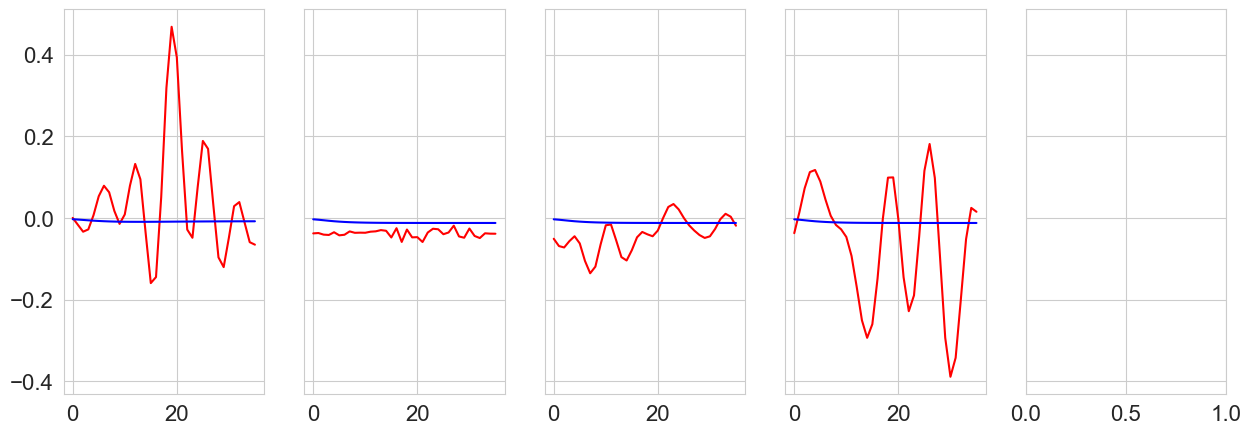

In [89]:
fig, ax =  plt.subplots(1, 5, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(X_augmented[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(X_augmented[4, :, 0], color="blue")

ax[2].plot(x_train[4, :, 0], color="red")
ax[2].plot(X_augmented[4, :, 0], color="blue")

ax[3].plot(x_train[6, :, 0], color="red")
ax[3].plot(X_augmented[6, :, 0], color="blue")

plt.show()

In [ ]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200


### CNN-1D Basic model
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128, 5, padding='same', activation='relu')(input_layer)
    cnn = tfkl.Conv1D(128, 5, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128, 1, padding='same', activation='relu')(cnn)
    cnn = tfkl.Conv1D(128, 1, padding='same', activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
predictions = model.predict(x_test)
predictions.shape

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()